In [20]:
import pyro
from pyro.distributions import Bernoulli

def causal_model(stress_pt, smokes_cpt, cancer_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    smokes = pyro.sample("smokes", Bernoulli(smokes_cpt[stress])).long()
    cancer = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()

    return stress, smokes, cancer

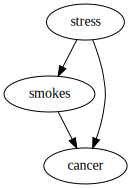

In [21]:
import torch

stress_pt = torch.tensor([0.5])
smokes_cpt  = torch.tensor([0.2, 0.8])
cancer_cpt  = torch.tensor([[0.1, 0.15], 
                            [0.8, 0.85]])

pyro.render_model(causal_model, (stress_pt, smokes_cpt, cancer_cpt))

In [22]:
n_individuals = 10000

with pyro.plate("individuals", n_individuals, dim=-1):
    stress_obs, smokes_obs, cancer_obs = causal_model(stress_pt, smokes_cpt, cancer_cpt)

print(stress_obs.shape, smokes_obs.shape, cancer_obs.shape)

torch.Size([10000]) torch.Size([10000]) torch.Size([10000])


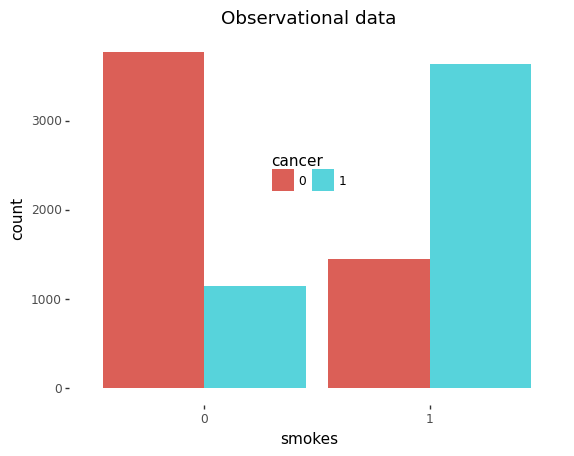

<ggplot: (8731864578289)>

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data_obs = torch.concat((stress_obs.reshape(-1, 1), smokes_obs.reshape(-1, 1), cancer_obs.reshape(-1, 1)), axis=-1)

frame_obs = pd.DataFrame(data_obs.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})

#sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_obs).set(title='Observational Data')

from plotnine import *

def ggbarplot(data, title, position = (.5,.6)):
    return ggplot(data, aes( x = "smokes", fill = "cancer"))+geom_bar(
        position = "dodge") + theme_tufte(        
        ) + theme(legend_position= position
        )+ ggtitle(title)
    
obsPlot = ggbarplot(frame_obs, "Observational data")

obsPlot

In [24]:
def always_smokes_model(stress_pt, smokes_cpt, cancer_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    # smokes no longer depends on stress.
    smokes   = pyro.deterministic("smokes", torch.ones_like(stress))
    cancer   = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()

    return stress, smokes, cancer

def never_smokes_model(stress_pt, smokes_cpt, cancer_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    # smokes no longer depends on stress.
    smokes   = pyro.deterministic("smokes", torch.zeros_like(stress))
    cancer   = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()

    return stress, smokes, cancer

# Let's imagine that we force half the people to always smoke and half to never smoke.
n_counterfactual_individuals = int(n_individuals/2)
with pyro.plate("counterfactual_individuals", n_counterfactual_individuals, dim=-1):
    stress_as, smokes_as, cancer_as = always_smokes_model(stress_pt, smokes_cpt, cancer_cpt)
    stress_ns, smokes_ns, cancer_ns = never_smokes_model(stress_pt, smokes_cpt, cancer_cpt)



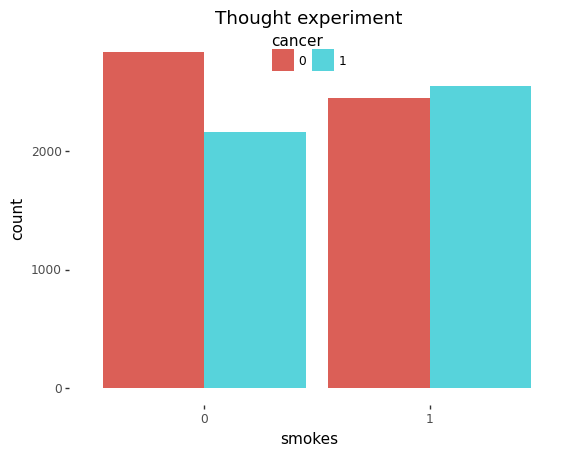

<ggplot: (8731864524266)>

In [25]:
data_as = torch.concat((stress_as.reshape(-1, 1), smokes_as.reshape(-1, 1), cancer_as.reshape(-1, 1)), axis=-1)
data_ns = torch.concat((stress_ns.reshape(-1, 1), smokes_ns.reshape(-1, 1), cancer_ns.reshape(-1, 1)), axis=-1)
data_int = torch.concat((data_as, data_ns))

frame_int = pd.DataFrame(data_int.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})

#_, ax = plt.subplots(1, 2, sharey=True)

#sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_obs, ax=ax[0]).set(title='Observational Data')
#sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_int, ax=ax[1]).set(title='Thought Experiment')



ggbarplot(frame_int, "Thought experiment", position = (.5,.85))


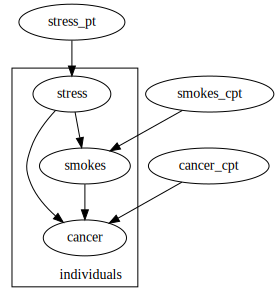

In [26]:
from causal_pyro.query.do_messenger import do

always_smokes_model = do(causal_model, {"smokes": torch.tensor([1.])})
never_smokes_model  = do(causal_model, {"smokes": torch.tensor([0.])})

with pyro.plate("counterfactual_individuals", n_counterfactual_individuals, dim=-1):
    # Sample from a population of individuals under the "always smokes" thought experiment.
    stress_as, smokes_as, cancer_as = always_smokes_model(stress_pt, smokes_cpt, cancer_cpt)
    stress_ns, smokes_ns, cancer_ns = never_smokes_model(stress_pt, smokes_cpt, cancer_cpt)

from pyro.distributions import Beta

def parameter_prior():

    stress_pt = pyro.sample("stress_pt", Beta(torch.ones(1), torch.ones(1)).to_event(1))
    smokes_cpt = pyro.sample("smokes_cpt", Beta(torch.ones(2), torch.ones(2)).to_event(1))
    cancer_cpt = pyro.sample("cancer_cpt", Beta(torch.ones(2, 2), torch.ones(2, 2)).to_event(2)) 

    return stress_pt, smokes_cpt, cancer_cpt

def bayesian_causal_model(n_individuals):
    stress_pt, smokes_cpt, cancer_cpt = parameter_prior()

    with pyro.plate("individuals", n_individuals, dim=-1):
        # Call our original observational_model with parameters sampled from our prior above.
        return causal_model(stress_pt, smokes_cpt, cancer_cpt)


pyro.render_model(bayesian_causal_model, (n_individuals,))

In [27]:
def multipleRuns(model, times = 1000):
    
    cancer_if_no_smoke_prop = []
    cancer_if_smoke_prop = []

    pyro.set_rng_seed(101)

    for i in range(1000):
        stress_obs, smokes_obs, cancer_obs = model(n_individuals)
        cancer_if_no_smoke_prop.append(torch.mean((cancer_obs[smokes_obs == 0].float())))
        cancer_if_smoke_prop.append(torch.mean((cancer_obs[smokes_obs == 1].float())))

    cancer_if_no_smoke_prop = torch.stack(cancer_if_no_smoke_prop)
    cancer_if_smoke_prop = torch.stack(cancer_if_smoke_prop)

    averaged_obs = torch.concat((cancer_if_smoke_prop.reshape(-1, 1),
    cancer_if_no_smoke_prop.reshape(-1, 1), 
    torch.sub(cancer_if_smoke_prop, cancer_if_no_smoke_prop).reshape(-1,1)),
    axis =  - 1)

    averaged_df = pd.DataFrame(averaged_obs.numpy(),
                           columns=["smoking",
                                    "not_smoking", 
                                    "dif"])




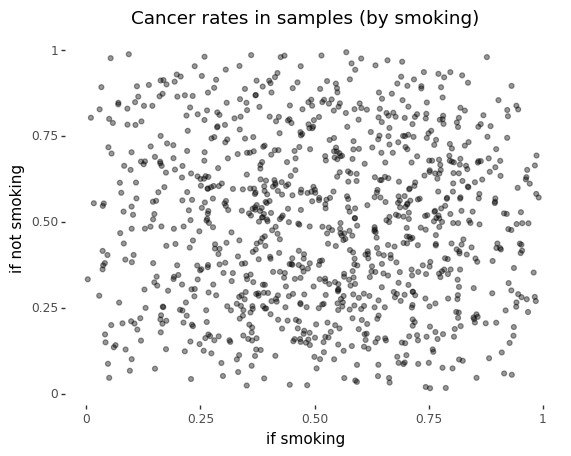

<ggplot: (8731864428316)>

In [28]:

ggplot(averaged_df, aes( x = "smoking", y = "not_smoking"))+geom_point(size = 1.5, alpha = .4) + theme_tufte(        
        ) + theme(legend_position= (.5,.5))+ ggtitle("Cancer rates in samples (by smoking)")+xlab("if smoking")+ylab("if not smoking")

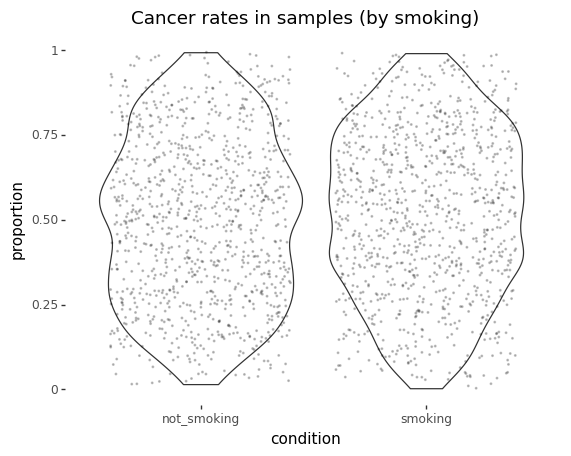

<ggplot: (8731864591601)>

In [29]:
averaged_df_long = pd.melt(averaged_df, value_vars = ("smoking", "not_smoking"),  var_name = "condition", value_name = "proportion")


ggplot(averaged_df_long, aes( x = "condition", y = "proportion"))+geom_violin(size = .5, alpha = .4) + theme_tufte(        
        ) + theme(legend_position= (.5,.5))+ ggtitle("Cancer rates in samples (by smoking)")+geom_jitter(size = .2, alpha = .2)

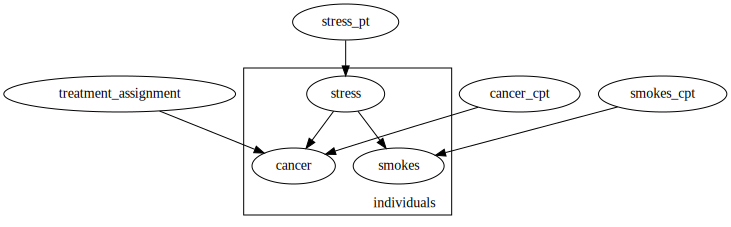

In [35]:
def randomized_intervention(model, intervention_variable, n_individuals):
    def new_model(*args, **kwargs):
        intervention_assignment = pyro.sample("treatment_assignment", Bernoulli(torch.ones(n_individuals) * 0.5).to_event(1)).long()
        return do(model, {intervention_variable: intervention_assignment})(*args, **kwargs)
    
    return new_model

bayesian_randomized_model = randomized_intervention(bayesian_causal_model, "smokes", n_individuals)

# TODO: explain this rendering a bit.
pyro.render_model(bayesian_randomized_model, (n_individuals,))

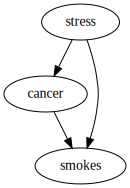

In [30]:

def alt_causal_model(stress_pt, cancer_cpt, smokes_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    cancer = pyro.sample("cancer", Bernoulli(cancer_cpt[stress])).long()
    smokes = pyro.sample("smokes", Bernoulli(smokes_cpt[stress, cancer])).long()

    return stress, smokes, cancer

stress_pt = torch.tensor([0.5])
cancer_cpt  = torch.tensor([0.2, 0.8])
smokes_cpt  = torch.tensor([[0.1, 0.15], 
                            [0.8, 0.85]])

pyro.render_model(alt_causal_model, (stress_pt, cancer_cpt, smokes_cpt))



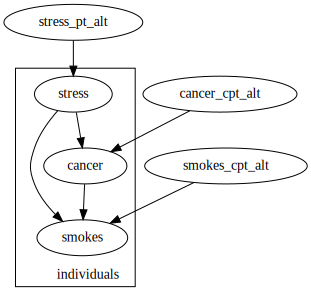

In [31]:
def alt_parameter_prior():

    stress_pt = pyro.sample("stress_pt_alt", Beta(torch.ones(1), torch.ones(1)).to_event(1))
    cancer_cpt = pyro.sample("cancer_cpt_alt", Beta(torch.ones(2), torch.ones(2)).to_event(1))
    smokes_cpt = pyro.sample("smokes_cpt_alt", Beta(torch.ones(2, 2), torch.ones(2, 2)).to_event(2)) 

    return stress_pt, cancer_cpt, smokes_cpt

def alt_bayesian_causal_model(n_individuals):
    stress_pt, cancer_cpt, smokes_cpt = alt_parameter_prior()

    with pyro.plate("individuals", n_individuals, dim=-1):
        # Call our original observational_model with parameters sampled from our prior above.
        return alt_causal_model(stress_pt, cancer_cpt, smokes_cpt)

pyro.render_model(alt_bayesian_causal_model, (n_individuals,))

In [32]:
cancer_if_no_smoke_prop_alt = []
cancer_if_smoke_prop_alt = []

pyro.set_rng_seed(101)

for i in range(1000):
    stress_obs, smokes_obs, cancer_obs = alt_bayesian_causal_model(n_individuals)
    cancer_if_no_smoke_prop_alt.append(torch.mean((cancer_obs[smokes_obs == 0].float())))
    cancer_if_smoke_prop_alt.append(torch.mean((cancer_obs[smokes_obs == 1].float())))

cancer_if_no_smoke_prop_alt = torch.stack(cancer_if_no_smoke_prop_alt)
cancer_if_smoke_prop_alt = torch.stack(cancer_if_smoke_prop_alt)


averaged_obs_alt = torch.concat((cancer_if_smoke_prop_alt.reshape(-1, 1),
cancer_if_no_smoke_prop_alt.reshape(-1, 1), 
torch.sub(cancer_if_smoke_prop_alt, cancer_if_no_smoke_prop_alt).reshape(-1,1)),
 axis =  - 1)



averaged_df_alt = pd.DataFrame(averaged_obs_alt.numpy(),
                           columns=["smoking",
                                    "not_smoking", 
                                    "dif"])


KeyboardInterrupt: 

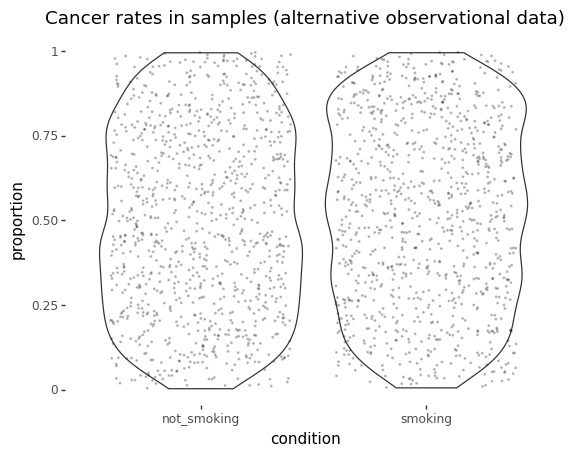

<ggplot: (8731870448061)>

In [ ]:
averaged_df_alt_long = pd.melt(averaged_df_alt, value_vars = ("smoking", "not_smoking"),  var_name = "condition", value_name = "proportion")


ggplot(averaged_df_alt_long, aes( x = "condition", y = "proportion"))+geom_violin(size = .5, alpha = .4) + theme_tufte(        
        ) + theme(legend_position= (.5,.5))+ ggtitle("Cancer rates in samples (alternative observational data)")+geom_jitter(size = .2, alpha = .2)

In [33]:
alt_bayesian_randomized_model = randomized_intervention(alt_bayesian_causal_model, "smokes", n_individuals)

NameError: name 'randomized_intervention' is not defined